In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Part 1: Data Preparation and Exploration.

In [2]:
# Load the dataset
df = pd.read_csv('exchange_rate.csv', parse_dates=[0])

# Display basic info and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


(None,
                date  Ex_rate
 0  01-01-1990 00:00   0.7855
 1  02-01-1990 00:00   0.7818
 2  03-01-1990 00:00   0.7867
 3  04-01-1990 00:00   0.7860
 4  05-01-1990 00:00   0.7849)

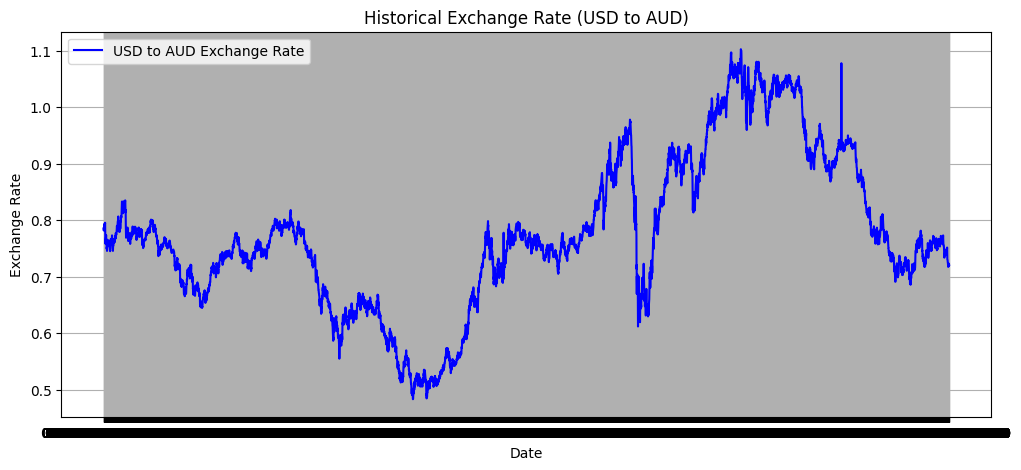

In [3]:
# Plot the time series data
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['Ex_rate'], label='USD to AUD Exchange Rate', color='blue')
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Historical Exchange Rate (USD to AUD)")
plt.legend()
plt.grid()
plt.show()

In [4]:
# Check for missing values
missing_values = df.isnull().sum()

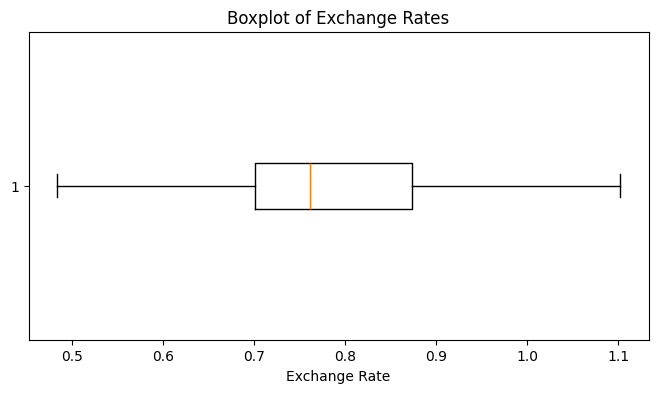

In [5]:
# Check for outliers using a boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(df['Ex_rate'], vert=False)
plt.title("Boxplot of Exchange Rates")
plt.xlabel("Exchange Rate")
plt.show()

In [6]:
missing_values

date       0
Ex_rate    0
dtype: int64

# Part 2: Building the ARIMA model

In [7]:
!pip install statsmodels

In [8]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [9]:
# Perform Augmented Dickey-Fuller test to check stationarity
adf_test = adfuller(df['Ex_rate'])
adf_result = {"ADF Statistic": adf_test[0], "p-value": adf_test[1]}

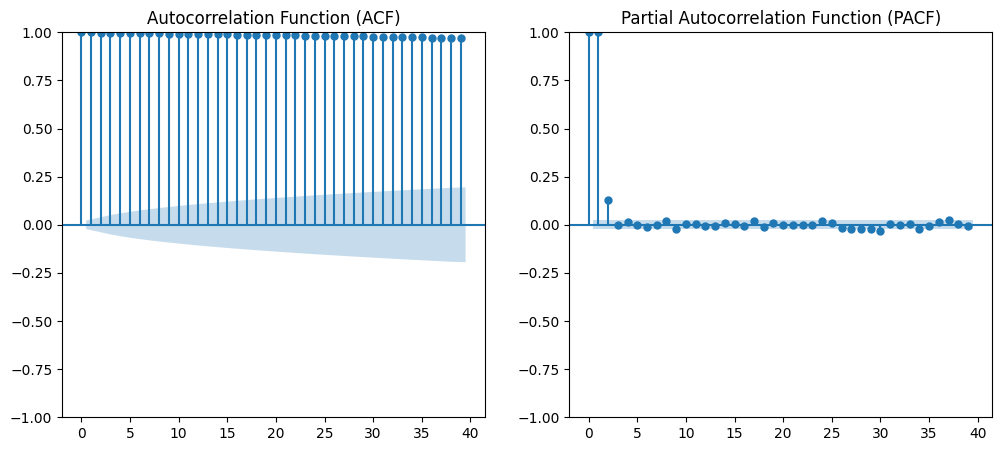

In [10]:
# Plot ACF and PACF to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Ex_rate'], ax=axes[0])
plot_pacf(df['Ex_rate'], ax=axes[1])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

In [11]:
# Display ADF test result
adf_result

{'ADF Statistic': np.float64(-1.6649941807381528),
 'p-value': np.float64(0.4492327353597901)}

In [12]:
# Apply first-order differencing
df['Ex_rate_diff'] = df['Ex_rate'].diff().dropna()

In [13]:
# Perform ADF test on differenced data
adf_test_diff = adfuller(df['Ex_rate_diff'].dropna())
adf_result_diff = {"ADF Statistic": adf_test_diff[0], "p-value": adf_test_diff[1]}

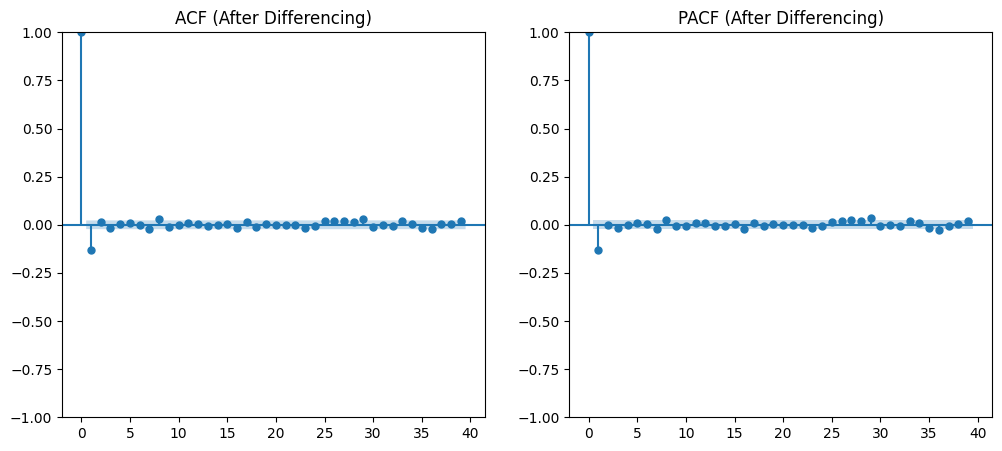

In [14]:
# Plot ACF and PACF after differencing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Ex_rate_diff'].dropna(), ax=axes[0])
plot_pacf(df['Ex_rate_diff'].dropna(), ax=axes[1])
axes[0].set_title("ACF (After Differencing)")
axes[1].set_title("PACF (After Differencing)")
plt.show()

In [15]:
# Display new ADF test result
adf_result_diff

{'ADF Statistic': np.float64(-99.39343120118629), 'p-value': 0.0}

In [16]:
from statsmodels.tsa.arima.model import ARIMA


In [17]:
# Fit ARIMA model (initial values: p=1, d=1, q=1)
arima_model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
arima_fit = arima_model.fit()

In [18]:
# Summary of the model
arima_summary = arima_fit.summary()
arima_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 18 Mar 2025   AIC                         -56102.322
Time:                        22:07:39   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.000    3.58e-05    3.62e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2865078.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
import seaborn as sns

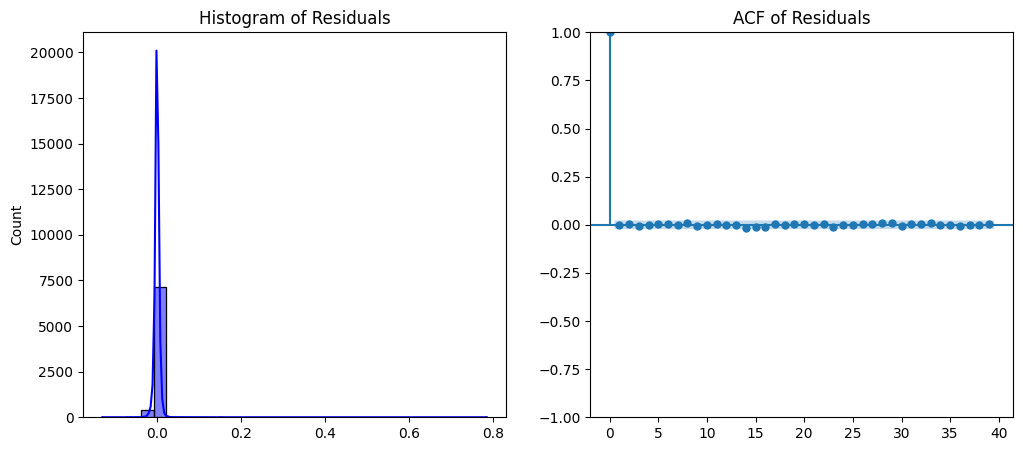

In [20]:
# Plot residuals
residuals = arima_fit.resid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals, bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Histogram of Residuals")

sm.graphics.tsa.plot_acf(residuals, ax=axes[1])
axes[1].set_title("ACF of Residuals")

plt.show()

In [21]:
# Forecast the next 12 months
forecast_steps = 12
forecast_arima = arima_fit.forecast(steps=forecast_steps)

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Create a date range for the forecast
last_date = df['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

In [26]:
# Ensure forecast_dates is in proper datetime format
forecast_dates = pd.date_range(start=df['date'].iloc[-1], periods=forecast_steps+1, freq='M')[1:]

TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x0000023111B73750>.

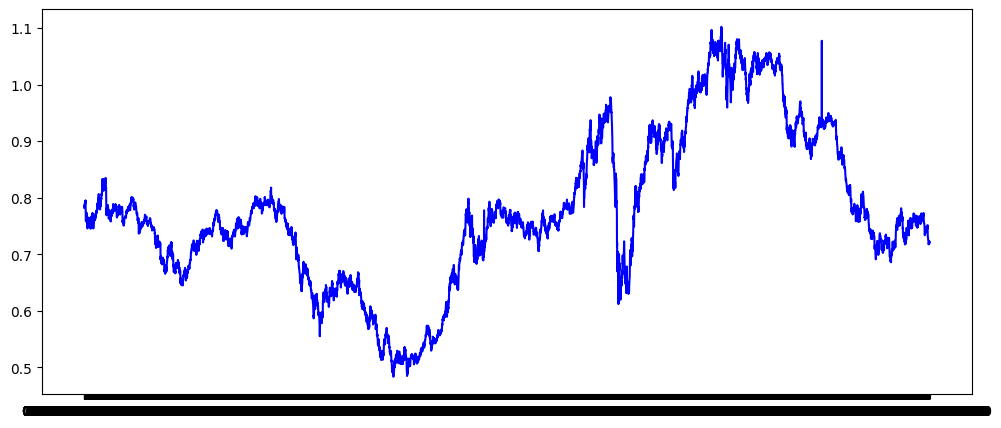

In [27]:
# plot the actual vs. predicted values
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['Ex_rate'], label="Actual", color='blue')
plt.plot(forecast_dates, forecast_arima, label="Forecast (ARIMA)", linestyle='dashed', color='red')
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("ARIMA Model - Exchange Rate Forecast")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Display forecasted values
forecast_arima

# Part 3: Exponential Smoothing model.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Fit Exponential Smoothing model (Holt's Linear Trend Model)
exp_smooth_model = ExponentialSmoothing(df['Ex_rate'], trend="add", seasonal=None, damped_trend=False)
exp_smooth_fit = exp_smooth_model.fit()

In [ ]:
# Forecast for the next 12 months
forecast_exp = exp_smooth_fit.forecast(steps=forecast_steps)

In [ ]:
# Plot actual vs forecasted values
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['Ex_rate'], label="Actual", color='blue')
plt.plot(forecast_dates, forecast_exp, label="Forecast (Exp. Smoothing)", linestyle='dashed', color='green')
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.title("Exponential Smoothing Forecast of Exchange Rate (USD to AUD)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Display forecasted values
forecast_exp

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Compute error metrics for ARIMA and Exponential Smoothing
actual_values = df['Ex_rate'].iloc[-forecast_steps:]

mae_arima = mean_absolute_error(actual_values, forecast_arima)
rmse_arima = mean_squared_error(actual_values, forecast_arima, squared=False)
mape_arima = (abs(actual_values - forecast_arima) / actual_values).mean() * 100

mae_exp = mean_absolute_error(actual_values, forecast_exp)
rmse_exp = mean_squared_error(actual_values, forecast_exp, squared=False)
mape_exp = (abs(actual_values - forecast_exp) / actual_values).mean() * 100

In [ ]:
# Display comparison results
error_metrics = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing"],
    "MAE": [mae_arima, mae_exp],
    "RMSE": [rmse_arima, rmse_exp],
    "MAPE (%)": [mape_arima, mape_exp]
})

error_metrics